<a href="https://colab.research.google.com/github/tahiya-062/tahiya-062/blob/main/Foundations_of_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:

from google.colab import files
uploaded = files.upload()

import pandas as pd


Saving dataset2.csv to dataset2 (1).csv


In [10]:
df1 = pd.read_csv("/content/dataset1.csv")
df2 = pd.read_csv("/content/dataset2.csv")
print("Dataset1 shape:", df1.shape)
print("Dataset2 shape:", df2.shape)

Dataset1 shape: (907, 12)
Dataset2 shape: (2123, 7)


In [11]:

# Importing necessary libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

In [12]:
# Creating output folder
OUT_DIR = "Bat_Vs_Rat_assignment_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [13]:
# Loading Datasets
df1 = pd.read_csv("dataset1.csv")
df2 = pd.read_csv("dataset2.csv")
print("Dataset1 shape:", df1.shape)
print("Dataset2 shape:", df2.shape)

Dataset1 shape: (907, 12)
Dataset2 shape: (2123, 7)


Cleaning dataset1

In [14]:
df = df1.copy()
df.columns = [c.strip() for c in df.columns]

# Converting numerics
for col in ['bat_landing_to_food','seconds_after_rat_arrival','hours_after_sunset','risk','reward']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Converting binary columns to integer
if 'risk' in df.columns:
    df['risk'] = df['risk'].astype('Int64')
if 'reward' in df.columns:
    df['reward'] = df['reward'].astype('Int64')

# Converting to date/time
for col in ['start_time','rat_period_start','rat_period_end','sunset_time']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Duration of rat presence
if 'rat_period_start' in df.columns and 'rat_period_end' in df.columns:
    df['rat_present_duration_s'] = (df['rat_period_end'] - df['rat_period_start']).dt.total_seconds()

# Time-since-rat category
if 'seconds_after_rat_arrival' in df.columns:
    bins = [-1,0,10,60,3600,np.inf]
    labels = ['0s','1-10s','10-60s','1-60min','>1hr']
    df['time_since_rat_cat'] = pd.cut(df['seconds_after_rat_arrival'], bins=bins, labels=labels)

# Removing rows with missing important values
important_cols = ['bat_landing_to_food','seconds_after_rat_arrival','risk']
df_clean = df.dropna(subset=important_cols).copy()

print("Rows after cleaning:", df_clean.shape[0])

# Saving cleaned dataset
df_clean.to_csv(os.path.join(OUT_DIR, "dataset1_cleaned.csv"), index=False)

Rows after cleaning: 907


/tmp/ipython-input-1694530958.py:18: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipython-input-1694530958.py:18: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipython-input-1694530958.py:18: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipython-input-1694530958.py:18: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetim

Cleaning dataset2

In [15]:


d2 = df2.copy()
d2.columns = [c.strip() for c in d2.columns]
for col in ['bat_landing_number','food_availability','rat_minutes','rat_arrival_number','hours_after_sunset']:
    if col in d2.columns:
        d2[col] = pd.to_numeric(d2[col], errors='coerce')
d2.to_csv(os.path.join(OUT_DIR, "dataset2_cleaned.csv"), index=False)

Exploratory data analysis

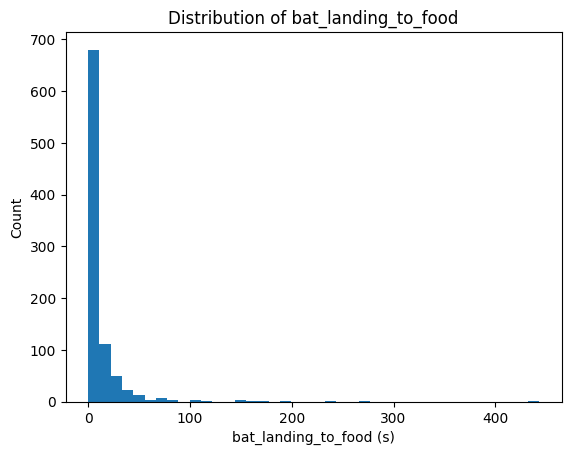

In [16]:

# Histogram
plt.hist(df_clean['bat_landing_to_food'].dropna(), bins=40)
plt.xlabel('bat_landing_to_food (s)')
plt.ylabel('Count')
plt.title('Distribution of bat_landing_to_food')
plt.show()

/tmp/ipython-input-1313483300.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=['risk=0','risk=1'], showfliers=False)


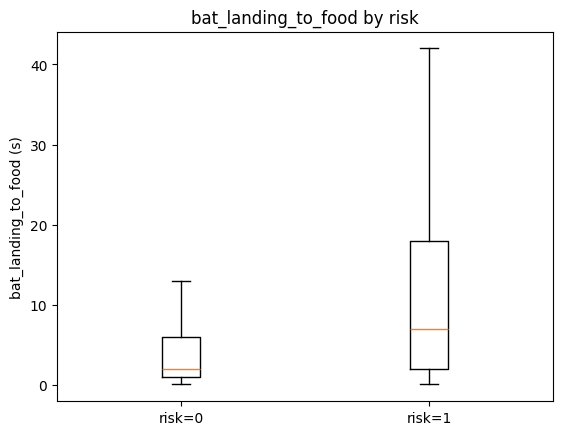

In [17]:
# Plotting by risk
groups = [df_clean[df_clean['risk']==0]['bat_landing_to_food'].dropna(),
          df_clean[df_clean['risk']==1]['bat_landing_to_food'].dropna()]
plt.boxplot(groups, labels=['risk=0','risk=1'], showfliers=False)
plt.ylabel('bat_landing_to_food (s)')
plt.title('bat_landing_to_food by risk')
plt.show()

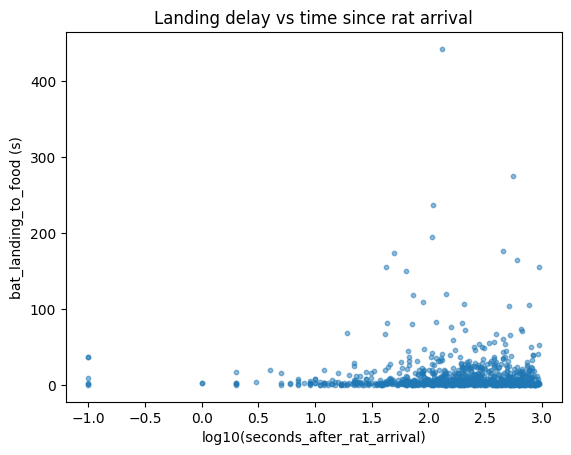

In [18]:
# Scattering
x = df_clean['seconds_after_rat_arrival'].replace(0,0.1)
plt.scatter(np.log10(x), df_clean['bat_landing_to_food'], alpha=0.5, s=10)
plt.xlabel('log10(seconds_after_rat_arrival)')
plt.ylabel('bat_landing_to_food (s)')
plt.title('Landing delay vs time since rat arrival')
plt.show()

In [19]:
# Mann-Whitney U test

g0 = df_clean[df_clean['risk']==0]['bat_landing_to_food'].dropna()
g1 = df_clean[df_clean['risk']==1]['bat_landing_to_food'].dropna()
U, p = stats.mannwhitneyu(g0, g1, alternative='two-sided')
print("Mann-Whitney U:", U, "p-value:", p)

Mann-Whitney U: 68002.0 p-value: 8.431265724019709e-19


In [20]:
# Logistic regression

model_df = df_clean.copy()
predictors = ['bat_landing_to_food','seconds_after_rat_arrival']
if 'hours_after_sunset' in model_df.columns:
    predictors.append('hours_after_sunset')
if 'reward' in model_df.columns:
    predictors.append('reward')

In [21]:
# season dummies
if 'season' in model_df.columns:
    season_dummies = pd.get_dummies(model_df['season'].astype(str), prefix='season', drop_first=True)
    model_df = pd.concat([model_df, season_dummies], axis=1)
    predictors += list(season_dummies.columns)

In [22]:
model_df = model_df.dropna(subset=predictors+['risk'])
X = sm.add_constant(model_df[predictors])
y = model_df['risk'].astype(int)

In [24]:
# Try Logit, fallback to GLM
  # Define target and predictors
y = df_clean['risk']   # binary target (0 or 1)

X = df_clean[['bat_landing_to_food', 'seconds_after_rat_arrival', 'season']]

# Convert categorical columns (like 'season') into dummies
X = pd.get_dummies(X, drop_first=True)

# Add constant for intercept
X = sm.add_constant(X)

# Fit logistic regression
logit = sm.Logit(y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.668521
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   risk   No. Observations:                  907
Model:                          Logit   Df Residuals:                      903
Method:                           MLE   Df Model:                            3
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                 0.03546
Time:                        15:19:17   Log-Likelihood:                -606.35
converged:                       True   LL-Null:                       -628.64
Covariance Type:            nonrobust   LLR p-value:                 1.135e-09
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0698      0.177      0.394      0.693      -0.

In [27]:
# Target variable
y = df_clean['risk'].astype(int)

# Example predictors
X = df_clean[['bat_landing_to_food', 'seconds_after_rat_arrival', 'season']]

# Convert categorical variables (like season) into dummies
X = pd.get_dummies(X, drop_first=True)

# Add constant (intercept)
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()
print(model.summary())
# Odds ratios
params = model.params
conf = model.conf_int()
ORs = pd.DataFrame({
    'coef': params,
    'odds_ratio': np.exp(params),
    'ci_lower': np.exp(conf[0]),
    'ci_upper': np.exp(conf[1]),
    'pvalue': model.pvalues
})
print("\nOdds Ratios:")
print(ORs)


Optimization terminated successfully.
         Current function value: 0.668521
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   risk   No. Observations:                  907
Model:                          Logit   Df Residuals:                      903
Method:                           MLE   Df Model:                            3
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                 0.03546
Time:                        15:23:33   Log-Likelihood:                -606.35
converged:                       True   LL-Null:                       -628.64
Covariance Type:            nonrobust   LLR p-value:                 1.135e-09
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0698      0.177      0.394      0.693      -0.

In [28]:
# AUC
y_prob = model.predict(X)
auc_val = roc_auc_score(y, y_prob)
print("AUC:", auc_val)

AUC: 0.6804811273961544


In [29]:
# Random Forest check

rf_X = X.drop(columns=['const'], errors='ignore').fillna(0)
rf_y = y
Xtrain,Xtest,ytrain,ytest = train_test_split(rf_X, rf_y, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(Xtrain,ytrain)
yhat = rf.predict(Xtest)
rf_auc = roc_auc_score(ytest, rf.predict_proba(Xtest)[:,1])
print("Random Forest AUC:", rf_auc)
print("Classification report:\n", classification_report(ytest, yhat))
print("Feature importances:\n", pd.Series(rf.feature_importances_, index=rf_X.columns).sort_values(ascending=False))

Random Forest AUC: 0.6068396733290351
Classification report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57       141
           1       0.54      0.54      0.54       132

    accuracy                           0.56       273
   macro avg       0.56      0.56      0.56       273
weighted avg       0.56      0.56      0.56       273

Feature importances:
 seconds_after_rat_arrival    0.575820
bat_landing_to_food          0.404981
season                       0.019199
dtype: float64


In [30]:
# Saving key outputs

summary = {
    "mannwhitney": {"U": float(U), "p": float(p)},
    "logistic_auc": float(auc_val),
    "rf_auc": float(rf_auc)
}
with open(os.path.join(OUT_DIR, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\nAll done. Results saved in", OUT_DIR)


All done. Results saved in Bat_Vs_Rat_assignment_outputs
